In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [3]:
# Read dataset & Preprocess text
# dataset = pd.read_csv('../input/isear-emotion/isear_dataset.csv')
df_train = pd.read_csv('../input/emotions-dataset-for-nlp/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('../input/emotions-dataset-for-nlp/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('../input/emotions-dataset-for-nlp/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

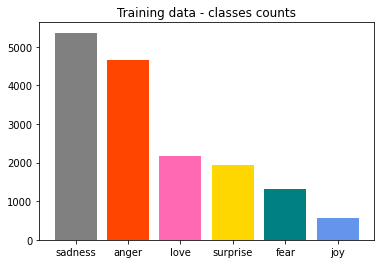

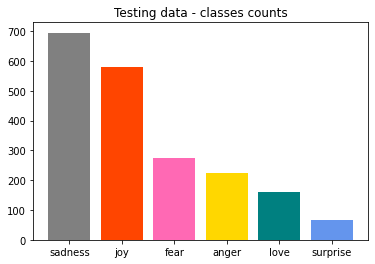

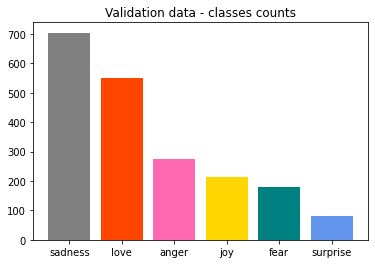

In [4]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [5]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [6]:

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [7]:
# Read GloVE embeddings

path_to_glove_file = '../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [8]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

2021-10-28 22:04:22.538679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 22:04:22.636652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 22:04:22.637374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 22:04:22.639331: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 200)          3237000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256, 512)          935936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256, 256)          656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 5,225,102
Trainable params: 1,988,102
Non-trainable params: 3,237,000
_________________________________________________________________


In [9]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [10]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10


2021-10-28 22:04:25.728881: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


63/63 [==============================] - 466s 7s/step - loss: 1.5958 - accuracy: 0.3412 - val_loss: 1.4975 - val_accuracy: 0.4455
Epoch 2/10
63/63 [==============================] - 455s 7s/step - loss: 1.2634 - accuracy: 0.5364 - val_loss: 1.0428 - val_accuracy: 0.6020
Epoch 3/10
63/63 [==============================] - 454s 7s/step - loss: 0.9634 - accuracy: 0.6313 - val_loss: 0.7217 - val_accuracy: 0.7405
Epoch 4/10
63/63 [==============================] - 458s 7s/step - loss: 0.5491 - accuracy: 0.8031 - val_loss: 0.3456 - val_accuracy: 0.8795
Epoch 5/10
63/63 [==============================] - 450s 7s/step - loss: 0.2486 - accuracy: 0.9054 - val_loss: 0.2339 - val_accuracy: 0.9055
Epoch 6/10
63/63 [==============================] - 448s 7s/step - loss: 0.1717 - accuracy: 0.9283 - val_loss: 0.1922 - val_accuracy: 0.9125
Epoch 7/10
63/63 [==============================] - 449s 7s/step - loss: 0.1354 - accuracy: 0.9381 - val_loss: 0.1551 - val_accuracy: 0.9255
Epoch 8/10
63/63 [======

In [11]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 26s 420ms/step - loss: 0.1389 - accuracy: 0.9290


[0.13890628516674042, 0.9290000200271606]

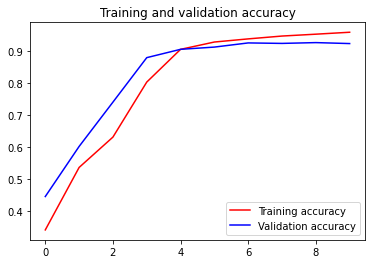

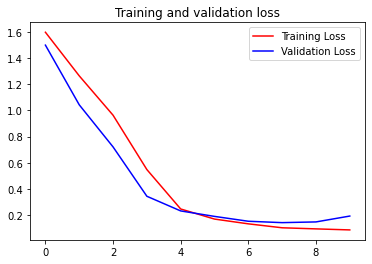

In [12]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
joy : 0.9680588245391846


Your point on this certain matter made me outrageous, how can you say so? This is insane.
anger : 0.5513092875480652


I can't do it, I'm not ready to lose anything, just leave me alone
fear : 0.448776513338089


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
surprise : 0.8797177076339722




In [14]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')